# **Computer Vision using FastAI**

This notebook will use the FastAI library to complete a computer vision task. 

I cannot reccommend the FastAI course highly enough. It's a great entry point in to Neural Networks and Deep Learning in general. Many of the explanations I provide below are snippets from the course.

You can find more information here:

https://www.fast.ai/

and the course here:

https://course.fast.ai/

I reccommend using Google Collab for the course, rather the a jupyter notebook.

# **Project: Pneumonia Prediction**

The problem: **Can we correctly classify chest X-Rays of patients that have pneumonia & those that do not?**

# Project plan

Here are the steps I plan to follow in this project:

* Import libraries & data

* Data overview - Show a few images, check classes, length of dataset etc.

* Train a model as a baseline

* Assess model misclassifications

* Model tuning:
    - Plot learning rates
    - Unfreeze the ResNet model
    - Use discriminative learning rates
    
It's also worth noting that I am following the above steps in order to gain more experience with FastAI - the particular steps I take may or may not be neccesary, I just want to utilise the various tools that FastAI offers.


# Importing the libraries

In [1]:
import random, os
import numpy as np
import torch
from fastai.vision.all import *

# Getting the data

I'll get the path for the dataset. This saves reading in data in the usual way, clogging up your notebook with thosands of image paths.

In [2]:
path = Path('/kaggle/input/chest-xray-pneumonia/chest_xray/'); path.ls()

(#5) [Path('/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray'),Path('/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX'),Path('/kaggle/input/chest-xray-pneumonia/chest_xray/val'),Path('/kaggle/input/chest-xray-pneumonia/chest_xray/test'),Path('/kaggle/input/chest-xray-pneumonia/chest_xray/train')]

DataLoader is a class that provides batches of a few items at a time - let's do that

In [3]:
data = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

dls = data.dataloaders(path)

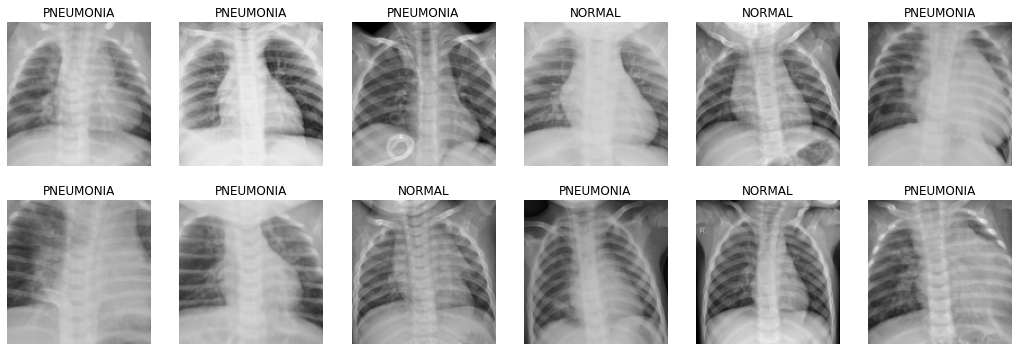

In [4]:
dls.valid.show_batch(max_n=12, nrows=2)

Observations from these images will be noted below. First, I'll do some more checks to confirm our **categories** are just 'Normal' and 'Pneumonia':

In [5]:
print(dls.vocab)

['NORMAL', 'PNEUMONIA']


And our **dataset length**

In [6]:
len(dls.train_ds), len(dls.valid_ds)

(9370, 2342)

# Observations

To the **untrained** eye it is difficult to say with certainty, looking at an X-ray, what visual distinctions there are between 'Normal' and those with 'Pneumonia'.

Perhaps the larger white mass in the chest is indicative of pneumonia, but this is conjecture on my part.

Also, our validation set is quite a lot smaller than our training set, but this isn't a problem. Actually, we often want our training set to be as large as possible!

# Baseline

Let's train a model.

FastAI has several ResNet models in readily available:

* Resnet18
* Resnet34
* Resnet50
* Resnet101
* Resnet152

They vary in size, with ResNet152 being trained on the most amount of images. 

For the basline, I will use **ResNet18**

In [7]:
learn = cnn_learner(dls, resnet18, metrics=[error_rate,accuracy])
learn.fine_tune(6)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.373673,0.212484,0.070880,0.929120,02:51


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.146567,0.096681,0.037148,0.962852,02:26
1,0.088726,0.060128,0.022203,0.977797,02:26
2,0.065395,0.058746,0.020495,0.979505,02:26
3,0.033904,0.037200,0.012810,0.987190,02:26
4,0.024504,0.038427,0.011102,0.988898,02:25
5,0.014747,0.034826,0.010675,0.989325,02:26


I'll save this model now

In [8]:
learn.save('model_1')

Path('models/model_1.pth')

**Fantastic results.**

This is often why **training a model quickly is a good place to start**. 

Why? Well, it prompts a number of questions:

* Is this score good enough already? 

* Do we have time to train more models? 

* Is optimization necessary?

These are all questions the may or may not provide direction in your specific domain. 

A fantastic course relevant to my point above is **"Structuting Machine Learning Projects"** by **Andrew Ng** on Coursera. 

It focuses on the practical realities of ML tools & products, optimization, setting a basline, and it is a fantastic resource. 

Here's a link:

https://www.coursera.org/learn/machine-learning-projects



In a medical domain, I'd say it is worth spending time to see if we can optimize further, but in some cases, a model such as the one above would be more than sufficient.

Now, where did we go wrong (and right)?

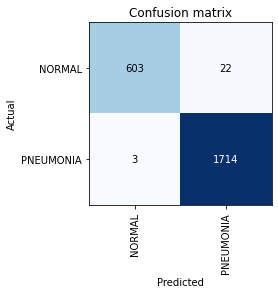

In [9]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

So we can see here that the **model did very well**. 

The main issuse the model has is producing **False Positives**. 20 Patients would be predicted to have pneumonia when in fact they do not. However, the more important metric in this case is **False Negatives**, of which there are 3. Not perfect, but a very good result overall.

We do note that we got some incorrect, we can view these explicitly.

Here, I'll choose the **top 3 losses**

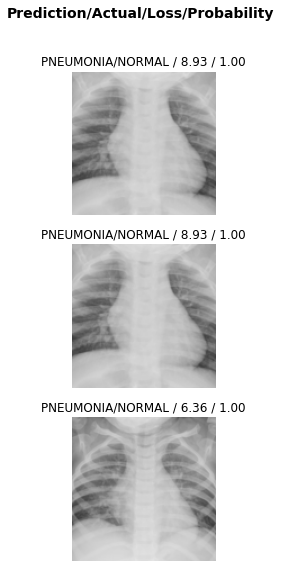

In [10]:
interp.plot_top_losses(3, nrows=3)

This can be an opportunity to *fix* issues in your dataset. For instance, if an image is incorrectly labelled. 

If you're using scraped data, for instance, this can be a problem. I built a classifier that can classify the Big Cats of Africa, and the amount of domestic cats that snuck in to the dataset was a real headache, so this can be a very important & useful step.

This relies on **domain expertise** though, so for this case I wouldn't attempt it. However, it is curious that the large white mass in the chest area on those incorrectly classified above do look very similar to the test batch we showed earlier.

# Improving the model

Adjusting the learning rate. If our learning rate is too low, it can take an age train our model. In addition, it means that we might overfit, because every time we do a complete pass through the data, we give our model a chance to memorize it. 

Seeing as the model did so well with ResNet18, I will continue to use that.

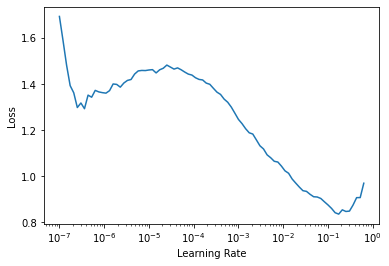

In [11]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
lr_min,lr_steep = learn.lr_find()

In [12]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 1.74e-02, steepest point: 8.32e-04


# Interpreting the Learner

The aim is to pick a learning rate that is not too high, and not too low.

The graph above helps us to ensure we acheive that.

Ideally, we want to pick a point where the Loss is still decreasing, and has not started to increase. Above, that happens at around 10^-1.

The decrease in Loss starts around 10^-4. I will pick between 10^-3 and 10^-2. 

Note that the Learner is on a logarithmic scale, which is why the middle point between 10^-3 and 10^-2 is between 3e-3 and 4e-3. 

Let's **re-train the model** for the same number of epochs but with the **new learning rate.**

In [13]:
learn = cnn_learner(dls, resnet18, metrics=[error_rate,accuracy])
learn.fine_tune(6, base_lr=5e-3)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.301524,0.191809,0.065756,0.934244,02:24


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.116359,0.079516,0.028181,0.971819,02:26
1,0.083261,0.111142,0.036294,0.963706,02:25
2,0.056355,0.097489,0.027754,0.972246,02:26
3,0.047219,0.051868,0.016652,0.983348,02:26
4,0.019711,0.028695,0.008113,0.991887,02:26
5,0.012776,0.030714,0.007686,0.992314,02:26


Let's save this model, too

In [14]:
learn.save('model_2')

Path('models/model_2.pth')

Fantastic, our model has **improved our accuracy due to changing the learning rate**.

As an aside, the default value that FastAI uses is 1e-3.

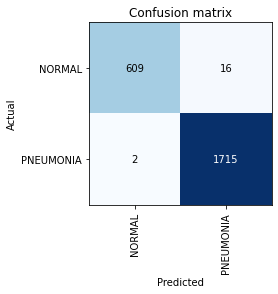

In [15]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

We can also normalize this plot to view the percentages.

This can be useful to gain perspective. 

For instance, we now see that our **recall is close to 100%** and that **False Negatives only occur 0.02% of the time**

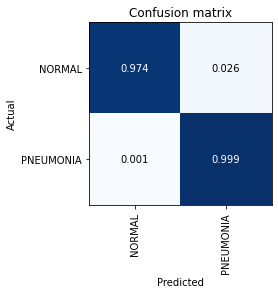

In [16]:
interp.plot_confusion_matrix(normalize=True, norm_dec=3)

The results are very good. We managed to **reduce the number of False Positives**. 

However the False Negatives are still the same. 

**We did improve the model** though, which was our aim.

These misclassifications are shown below explicitly:

In [17]:
interp.most_confused(min_val=1)

# Shown is 'ACTUAL, PREDICTED, COUNT'

[('NORMAL', 'PNEUMONIA', 16), ('PNEUMONIA', 'NORMAL', 2)]

Again, let's view the **top 3 losses**

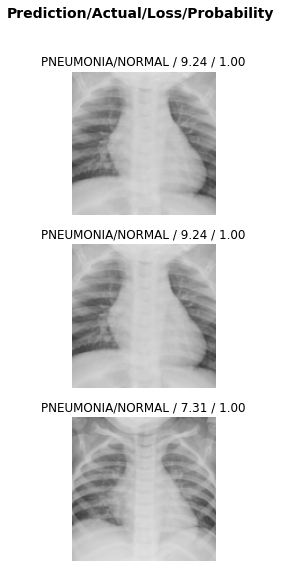

In [18]:
interp.plot_top_losses(3, nrows=3)

# How many epochs to train for?

Your first approach to training should be to simply pick a number of epochs that will **train in the amount of time you're willing to wait**.

Then look at the training and validation loss plots and in particular **your metrics**. If you see that they are still getting better even in your final epochs, then you know that you have not trained for too long.

**Remember, it's not just that we're looking for the validation loss to get worse, but the actual metrics**. This is an important realisation and can change how you approach machine learning & deep learning problems. If your desired metrics are improving, on the validation or test set, then that is the most important factor.

The loss function is just something that we use to allow our optimizer to have something it can differentiate and optimize; it's not actually the thing we care about in practice.

# Unfreezing the model

A pre trained model, such as the ResNet model we are using here, can be used on data other than the data it was trained on - this is **transfer learning**



Because the model was trained on some other dataset, we might be able to improve it by effectivley removing the final linear layer of the model - which is specifically designed to classify the categories in the original pretraining dataset - and replace it with a layer specific to our dataset.


From FastAI:

*We want to train a model in such a way that we allow it to remember all of these generally useful ideas from the pretrained model, use them to solve our particular task, and only adjust them as required for the specifics of our particular task.*

*Our challenge when fine-tuning is to replace the random weights in our added linear layers with weights that correctly achieve our desired task without breaking the carefully pretrained weights and the other layers. There is actually a very simple trick to allow this to happen: tell the optimizer to only update the weights in those randomly added final layers. Don't change the weights in the rest of the neural network at all. This is called freezing those pretrained layers.*

When we call the fine_tune method FastAI does two things:

* Trains the randomly added layers for one epoch, with all other layers frozen
* Unfreezes all of the layers, and trains them all for the number of epochs requested

Let's try that...

In [19]:
learn = cnn_learner(dls, resnet18, metrics=[error_rate,accuracy])
learn.fit_one_cycle(3, 5e-3)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.237544,0.137116,0.043553,0.956447,02:26
1,0.117934,0.083524,0.029462,0.970538,02:26
2,0.081694,0.072677,0.027754,0.972246,02:27


Next, unfreeze the model...

In [20]:
learn.unfreeze()

Now we can find a new learning rate

SuggestedLRs(lr_min=3.311311274956097e-07, lr_steep=7.585775847473997e-07)

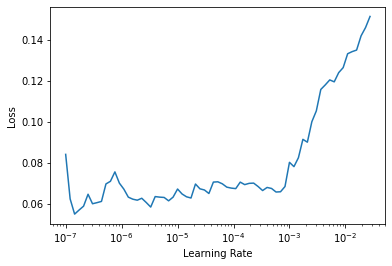

In [21]:
learn.lr_find()

In [22]:
learn.fit_one_cycle(5, lr_max=1e-6)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.064607,0.074052,0.026473,0.973527,02:27
1,0.069612,0.071784,0.025619,0.974381,02:28
2,0.073441,0.069057,0.025192,0.974808,02:27
3,0.060873,0.066699,0.023484,0.976516,02:28
4,0.058476,0.067298,0.024338,0.975662,02:28


The model didn't perform as well as the models above. 

I will now try another method...

# Discriminative Learning Rates

FastAI lets you pass a Python slice object anywhere that a learning rate is expected. The first value passed will be the learning rate in the earliest layer of the neural network, and the second value will be the learning rate in the final layer. 

I'll select a range here based on the plot above. 

I will then train for a while to see how the model performs. When our scores are already so high, it is hard to improve, so I am not expecting much improvement, if any, but I want to try this additional step

In [23]:
learn = cnn_learner(dls, resnet18, metrics=[error_rate,accuracy])
learn.fit_one_cycle(3, 5e-3)
learn.unfreeze()
learn.fit_one_cycle(8, lr_max=slice(5e-3,1e-3))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.209103,0.115307,0.039283,0.960717,02:28
1,0.110179,0.091577,0.030316,0.969684,02:32
2,0.075129,0.082055,0.030316,0.969684,02:36


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.145350,0.497047,0.151153,0.848847,02:30
1,0.150181,0.182970,0.061059,0.938941,02:31
2,0.128321,0.122606,0.047822,0.952178,02:30
3,0.107632,0.105464,0.042272,0.957728,02:30
4,0.100090,0.180513,0.078138,0.921862,02:30
5,0.063823,0.053987,0.020495,0.979505,02:31
6,0.043220,0.046238,0.017933,0.982067,02:31
7,0.028347,0.039236,0.011956,0.988044,02:31


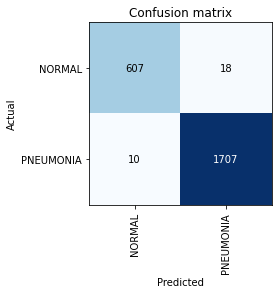

In [24]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

We certainly **didn't improve on our earlier results** - although 98% accuracy still can't be considered a poor result!

# Results

We were able to acheive an **accuracy score of over 99%**

This was accompanied by high precision & recall, with close to 100% of those with Pneumonia being detected successfully.

First, I set a baseline - which scored incredibly highly at the outset. From there, I knew it would be a challenge to improve the score.

Next, I adjuted the learning rate of the model and managed to improve the accuracy by nearly a full percentage point. This happens to be our final model.

I also tried unfreezing the base model, and also implementing disriminative learning rates. Though both of these still scored highly, neither matched up to earlier results. 

Overall, I am happy the the model is a success.

# **Thank you for reading**

Please consider upvoting if you found this notebook helpful.

# Some of my other work

**EDA & Prediction using SMOTE [HR Dataset]**

https://www.kaggle.com/joshuaswords/awesome-hr-data-visualization-prediction


**Stroke Prediction & Model Interpretation with SHAP, LIME, and ELI5**

https://www.kaggle.com/joshuaswords/predicting-a-stroke-shap-lime-explainer-eli5


**Beautiful EDA & Clustering [World Happiness Index 2021]**

https://www.kaggle.com/joshuaswords/awesome-eda-2021-happiness-population


**EDA & Gold Price Prediction using Prophet**

https://www.kaggle.com/joshuaswords/eda-gold-price-prediction-prophet
